# Skin Lesion Analyser (Skin Cancer Classification Based on Lesion Pigment)
---
    Skin cancer is a major public health problem with over 123,000 newly diagnosed cases worldwide in each year. Skin cancer is the most common form of cancer, globally accounting for at least 40% of cases. Skin cancer is diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

    The HAM10000 dataset consists of 10015 dermatoscopic images which are released as a training set for academic machine learning purposes and are publicly available through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

    It has 7 different classes of skin cancer which are listed below :
    1. Melanocytic nevi (nv) 4
    2. Melanoma (mel) 6
    3. Benign keratosis-like lesions (bkl) 2
    4. Basal cell carcinoma (bcc) 1
    5. Actinic keratoses (akiec) 0
    6. Vascular lesions (vasc) 5
    7. Dermatofibroma (df) 3

    Skin cancer lesion classification using the HAM10000 dataset

    Dataset link:
    https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

    Dataset description: 
    https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

    Reference code for processing data: 
    https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data



# Prepare all required library

In [60]:
!pip install -q kaggle
!pip install visualkeras

# !pip install keras==2.3.0
# !pip install tensorflow
# !pip install scikit-learn

In [61]:
# Data Prep
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np # for linear algebra

# Colab library to upload files to notebook
from google.colab import files

# Visualization lib
import pandas as pd # for data processing, CSV file I/O
import seaborn as sn
import json
import glob 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Report Metrics 
from sklearn import metrics

# Model Development
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU, GlobalMaxPooling2D, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
# import datetime
# from time import time
from glob import glob
from PIL import Image
import visualkeras

In [62]:
# Upload kaggle API key file
uploaded = files.upload()

In [63]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [64]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
!unzip skin-cancer-mnist-ham10000.zip -d dataset

Archive:  skin-cancer-mnist-ham10000.zip
replace dataset/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
n


In [66]:
!ls /content/dataset

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [67]:
print(len(os.listdir("dataset/HAM10000_images_part_1")))
print(len(os.listdir("dataset/HAM10000_images_part_2")))

5000
5015


# Showing metadata of HAM10000 dataset

In [68]:
df_data = pd.read_csv('dataset/HAM10000_metadata.csv')

print('Metadata dataset')
df_data.head(10)

Metadata dataset


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


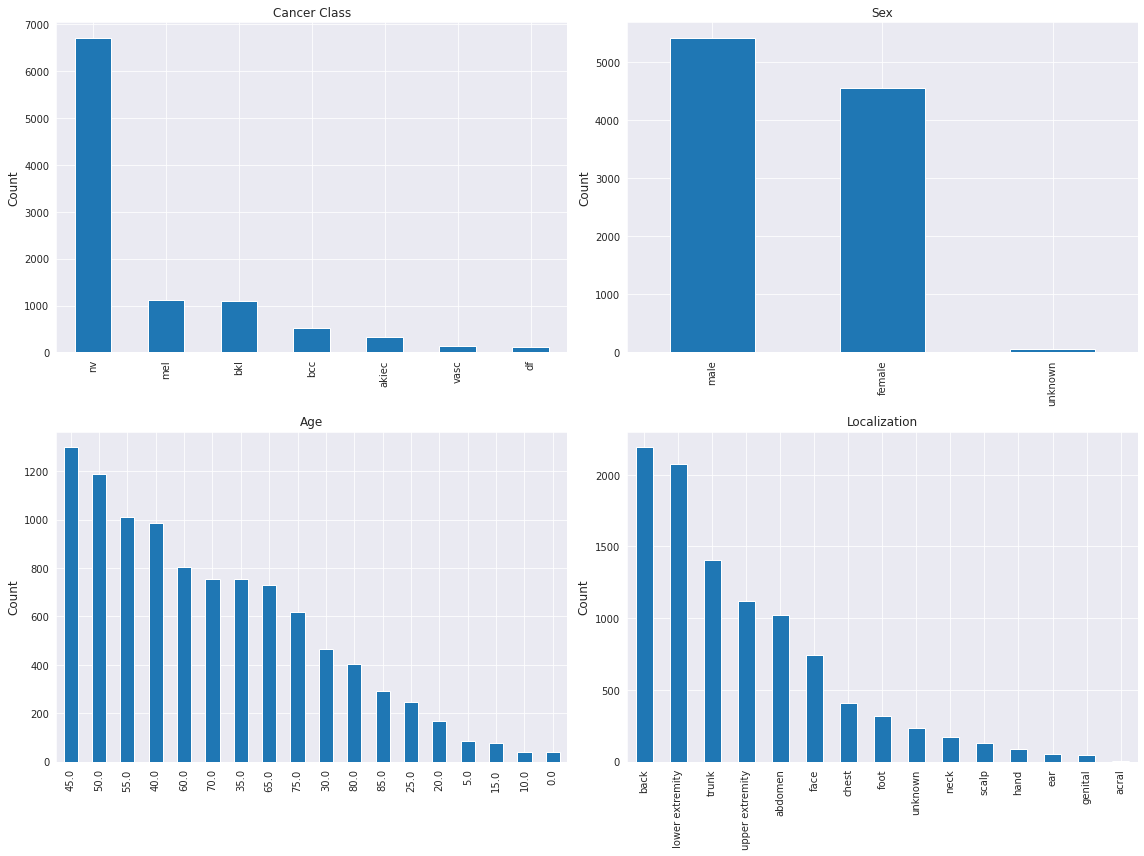

In [69]:
# visualization 
# Data distribution visualization
fig = plt.figure(figsize=(16,12))

class_plot = fig.add_subplot(221)
df_data['dx'].value_counts().plot(kind='bar', ax=class_plot)
class_plot.set_ylabel('Count', size=12)
class_plot.set_title('Cancer Class')

sex_plot = fig.add_subplot(222)
df_data['sex'].value_counts().plot(kind='bar', ax=sex_plot)
sex_plot.set_ylabel('Count', size=12)
sex_plot.set_title('Sex')

age_plot = fig.add_subplot(223)
df_data['age'].value_counts().plot(kind='bar')
age_plot.set_ylabel('Count',size=12)
age_plot.set_title('Age')

loc_plot = fig.add_subplot(224)
df_data['localization'].value_counts().plot(kind='bar')
loc_plot.set_ylabel('Count',size=12)
loc_plot.set_title('Localization')


plt.tight_layout()
plt.show()

In [70]:
# crate one hot encoding

# Class Cancer yang terdapat pada dataset
class_cancer = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

sex_dict = {
    'female' : 0,
    'male' : 1
}
location_dict = {
'scalp' : 0 , 'ear' : 1, 'face' : 2, 'back' : 3, 'trunk' : 4, 'chest' : 5,
       'upper extremity' : 6, 'abdomen' : 7, 'unknown' : 8, 'lower extremity' : 9,
       'genital' : 10, 'neck' : 11, 'hand' : 12, 'foot' : 13, 'acral' :  14}

#create a modification dataframe
df_data['sex'] = df_data['sex'].map(sex_dict.get)
df_data['localization'] = df_data['localization'].map(location_dict.get)
df_data['lesion']= df_data.dx.map(class_cancer)
df_data['lesion_idx'] = pd.Categorical(df_data['lesion']).codes
df_data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion,lesion_idx
4646,HAM_0002118,ISIC_0028249,nv,follow_up,40.0,0.0,3,Melanocytic nevi,4
8565,HAM_0000763,ISIC_0028217,nv,histo,35.0,0.0,3,Melanocytic nevi,4
8301,HAM_0001525,ISIC_0024355,nv,histo,35.0,1.0,6,Melanocytic nevi,4
7364,HAM_0002244,ISIC_0032549,nv,histo,25.0,0.0,5,Melanocytic nevi,4
556,HAM_0000979,ISIC_0028043,bkl,histo,70.0,1.0,0,Benign keratosis,2


In [71]:
print('Kelas yang terdapat pada dataset awal :', df_data['dx'].unique())
print(df_data.lesion.value_counts())

Kelas yang terdapat pada dataset awal : ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


## Checking null dataset

In [72]:
df_data.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex             57
localization     0
lesion           0
lesion_idx       0
dtype: int64

In [73]:
# # Cleaning the data
# df_data['age'].fillna((df_data['age'].mean()), inplace=True)
# df_data['sex'].fillna(df_data['sex'].value_counts().index[0], inplace=True)
# df_data.isnull().any()

In [74]:
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/dataset/', '*', '*.jpg'))}
df_data['path'] = df_data['image_id'].map(imageid_path_dict.get)
df_data.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion,lesion_idx,path
8081,HAM_0007164,ISIC_0025972,nv,histo,75.0,1.0,4,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...
5848,HAM_0007134,ISIC_0026394,nv,follow_up,60.0,1.0,7,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...
3616,HAM_0004256,ISIC_0027472,nv,follow_up,20.0,0.0,6,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...
4111,HAM_0003724,ISIC_0025036,nv,follow_up,50.0,0.0,7,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...
9498,HAM_0003968,ISIC_0032796,nv,consensus,35.0,0.0,3,Melanocytic nevi,4,/content/dataset/ham10000_images_part_2/ISIC_0...
734,HAM_0000149,ISIC_0031519,bkl,histo,70.0,0.0,9,Benign keratosis,2,/content/dataset/ham10000_images_part_2/ISIC_0...
1064,HAM_0007219,ISIC_0029227,bkl,consensus,70.0,1.0,12,Benign keratosis,2,/content/dataset/HAM10000_images_part_1/ISIC_0...
3134,HAM_0003788,ISIC_0026246,nv,follow_up,45.0,0.0,9,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...
1312,HAM_0003782,ISIC_0027102,mel,histo,35.0,0.0,7,Melanoma,5,/content/dataset/HAM10000_images_part_1/ISIC_0...
8402,HAM_0007480,ISIC_0024406,nv,histo,35.0,1.0,13,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_1/ISIC_0...


In [75]:
# from skimage.io import imread
# df_data['image'] = df_data['path'].map(imread)

# Loading and resize images
df_data['image'] = df_data['path'].map(lambda x: np.asarray(Image.open(x).resize((64, 64)))) # pixels of image

# Checking the image size distribution
df_data['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

In [76]:
df_data['image'].head()

0    [[[191, 152, 194], [191, 153, 195], [192, 149,...
1    [[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6...
2    [[[186, 129, 140], [192, 136, 151], [198, 143,...
3    [[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9...
4    [[[139, 95, 118], [158, 114, 138], [178, 133, ...
Name: image, dtype: object

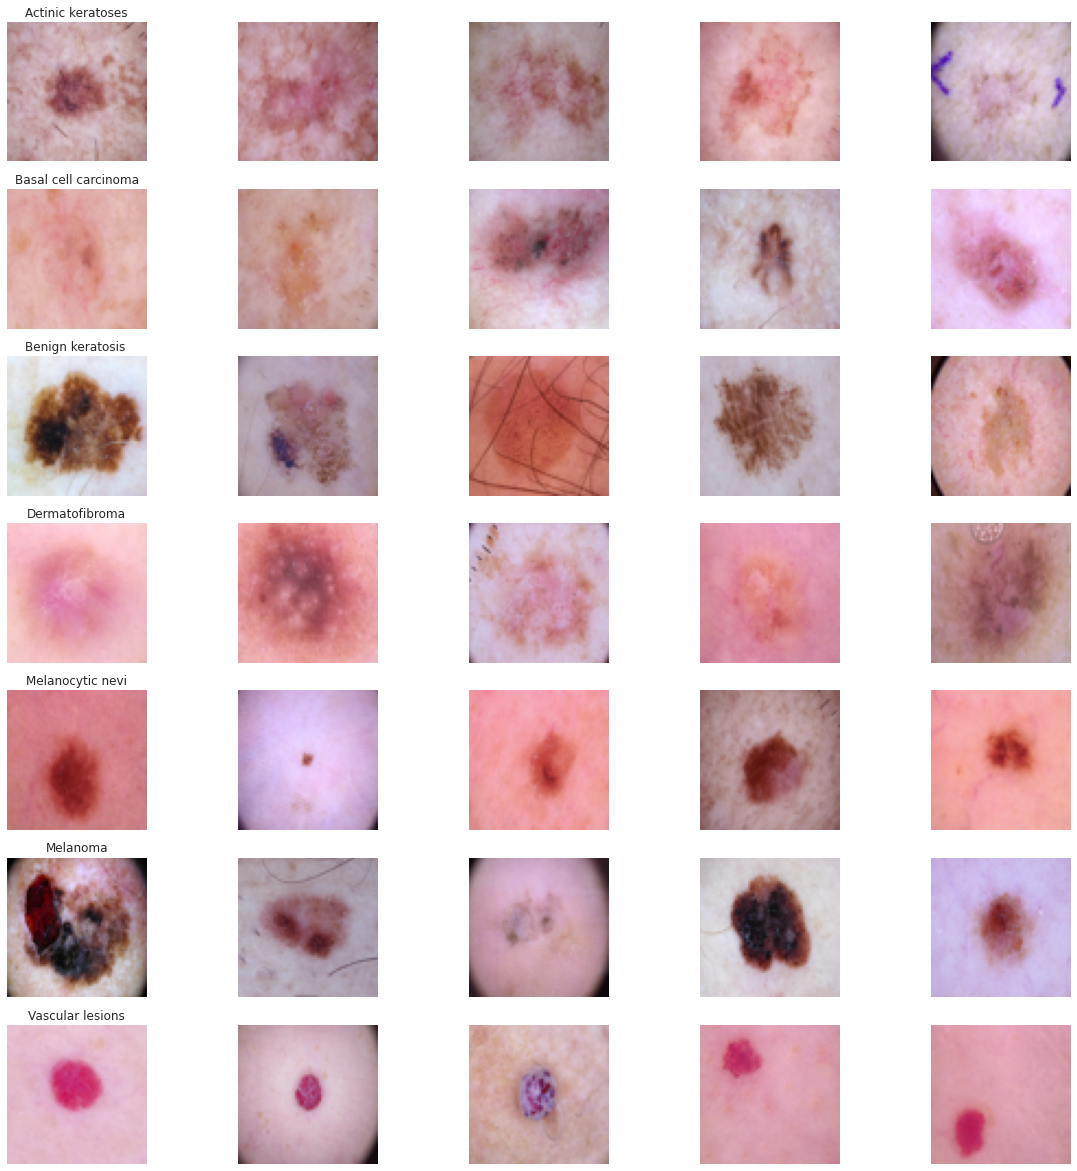

In [77]:
# Show image for each class cancer (dx)
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df_data.sort_values(['lesion']).groupby('lesion')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=10).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [78]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           9958 non-null   float64
 6   localization  10015 non-null  int64  
 7   lesion        10015 non-null  object 
 8   lesion_idx    10015 non-null  int8   
 9   path          10015 non-null  object 
 10  image         10015 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 792.3+ KB


In [79]:
df_data.to_csv ('metadata_skincancer.csv', index = False, header=True)

# Mengolah Model Menggunakan data hmnist_28_28_RGB.csv

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be

Shape of Data : (46935, 28, 28, 3)


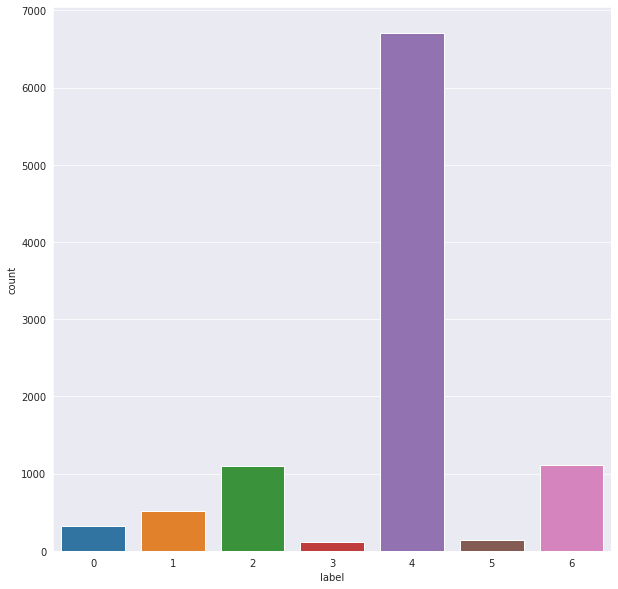

In [80]:
import seaborn as sns
import imblearn

Path = "/content/dataset/hmnist_28_28_RGB.csv"
dataSet = pd.read_csv(Path)
Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# from imblearn.over_sampling import RandomOverSampler 
# oversample = RandomOverSampler()
# Data,Label  = oversample.fit_resample(Data,Label)
# Data = np.array(Data).reshape(-1,28,28,3)
# print('Shape of Data :', Data.shape)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
Data,Label = sm.fit_resample(Data,Label)
Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of Data :', Data.shape)

In [81]:
dataSet["label"].value_counts().sort_index()

0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


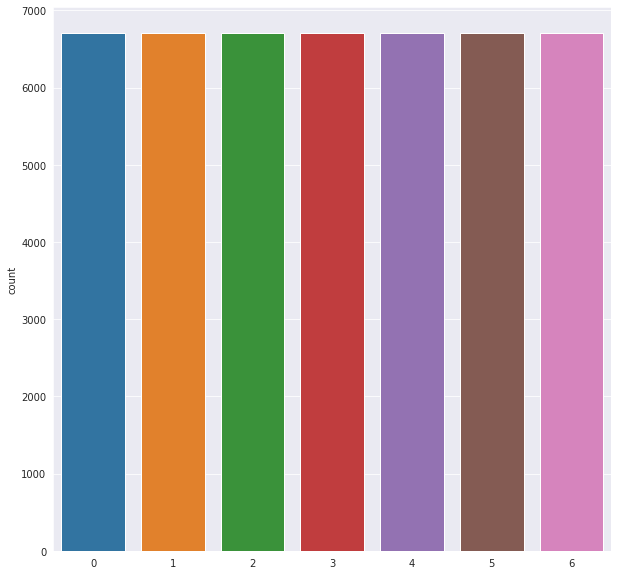

In [82]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

In [83]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [84]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 42)

In [85]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(11734, 28, 28, 3)
(35201,)
(11734,)


In [86]:
num_classes = 7
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [87]:
print("y_train")
print(y_train)
print("\n")
print("y_test")
print(y_test)

y_train
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


y_test
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


[[[216 131 153]
  [213 120 152]
  [217 135 161]
  ...
  [227 147 163]
  [225 147 161]
  [222 145 158]]

 [[210 123 141]
  [213 126 153]
  [216 134 158]
  ...
  [222 145 158]
  [223 147 162]
  [222 148 164]]

 [[210 129 144]
  [214 131 148]
  [220 143 163]
  ...
  [224 151 170]
  [225 152 172]
  [223 148 166]]

 ...

 [[207 136 135]
  [209 139 144]
  [211 145 152]
  ...
  [214 150 157]
  [212 149 155]
  [210 147 153]]

 [[207 138 139]
  [207 138 140]
  [208 141 149]
  ...
  [213 149 154]
  [212 149 155]
  [211 150 158]]

 [[205 137 140]
  [208 138 139]
  [208 139 148]
  ...
  [216 153 159]
  [213 149 156]
  [211 151 159]]]
(28, 28, 3)


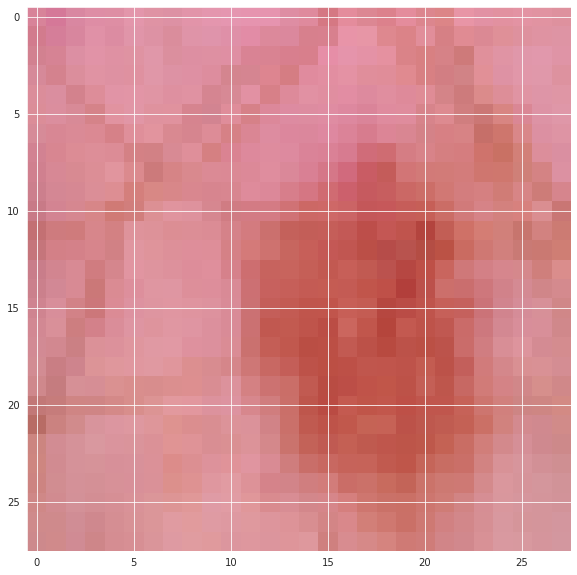

In [88]:
img = x_train[0]
print(img)
print(img.shape)
plt.imshow(img)

In [89]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias) 
  model = keras.models.Sequential([
  # model = Sequential()
  keras.layers.Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
  # keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  # model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu')
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Flatten(),
  keras.layers.Dense(256, activation = 'relu'),
  keras.layers.Dropout(0.25),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(128, activation = 'relu'),
  keras.layers.Dropout(0.2),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(64, activation = 'relu'),
  keras.layers.Dropout(0.15),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(32, activation = 'relu', kernel_regularizer=keras.regularizers.L1L2()),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(7, activation='softmax')])
  
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)

  return model

model = make_model()
# model.summary()

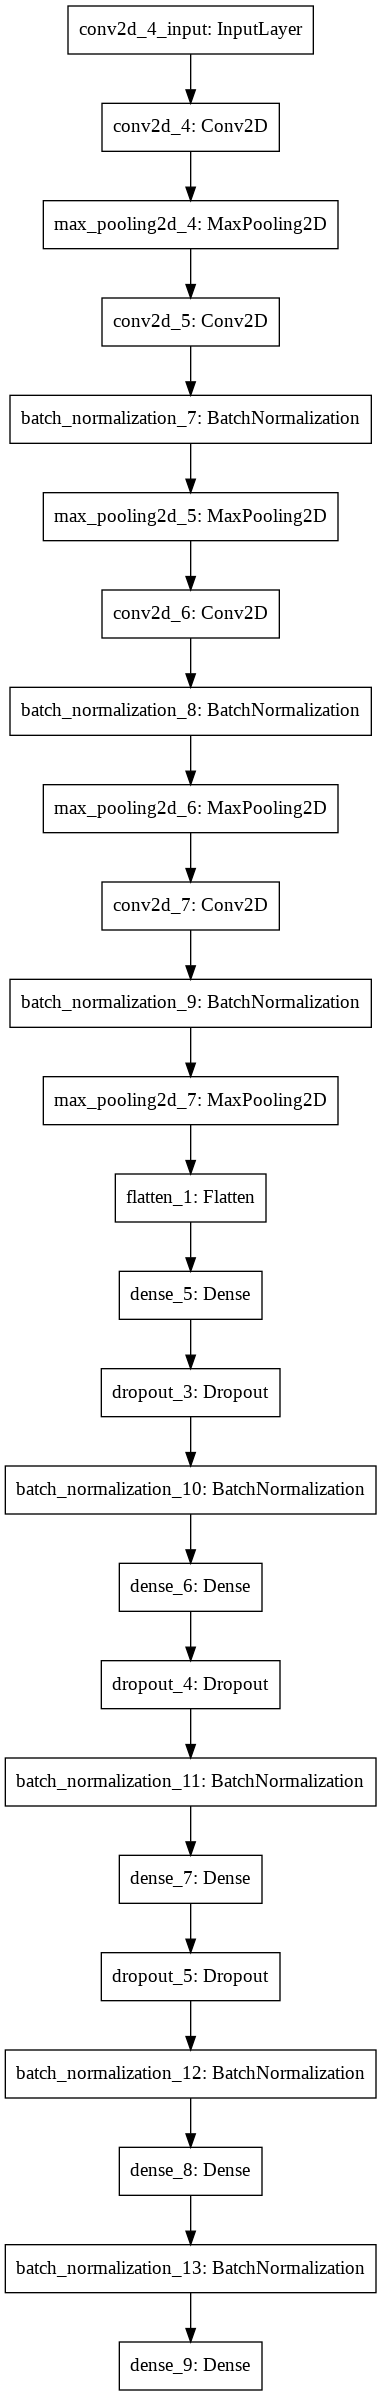

In [90]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model)

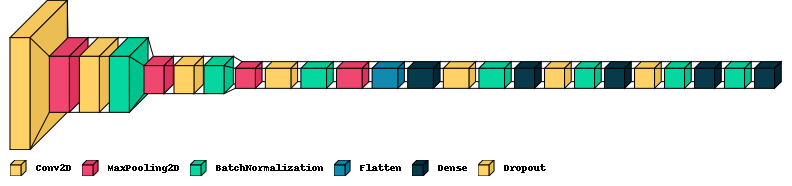

In [91]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(model, legend=True, font=font, to_file='visualkeras.png')

## Set for callbacks

In [92]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint("best_model_cutix.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min'
                             )

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [93]:
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size = 64,
    validation_data=(x_test, y_test), 
    shuffle=True, # testing shuffle
    callbacks=[learning_rate_reduction, early_stopping, checkpoint])

Epoch 1/20
551/551 [==============================] - 12s 16ms/step - loss: 1.2571 - tp: 11926.0000 - fp: 4942.0000 - tn: 206264.0000 - fn: 23275.0000 - accuracy: 0.8855 - precision: 0.7070 - recall: 0.3388 - auc: 0.8643 - prc: 0.5888 - val_loss: 1.4081 - val_tp: 4631.0000 - val_fp: 3659.0000 - val_tn: 66745.0000 - val_fn: 7103.0000 - val_accuracy: 0.8690 - val_precision: 0.5586 - val_recall: 0.3947 - val_auc: 0.8468 - val_prc: 0.5319

Epoch 00001: val_loss improved from inf to 1.40815, saving model to best_model_cutix.h5
Epoch 2/20
551/551 [==============================] - 8s 14ms/step - loss: 0.7330 - tp: 22980.0000 - fp: 5637.0000 - tn: 205569.0000 - fn: 12221.0000 - accuracy: 0.9275 - precision: 0.8030 - recall: 0.6528 - auc: 0.9548 - prc: 0.8240 - val_loss: 0.6563 - val_tp: 8422.0000 - val_fp: 2008.0000 - val_tn: 68396.0000 - val_fn: 3312.0000 - val_accuracy: 0.9352 - val_precision: 0.8075 - val_recall: 0.7177 - val_auc: 0.9629 - val_prc: 0.8509

Epoch 00002: val_loss improved fr

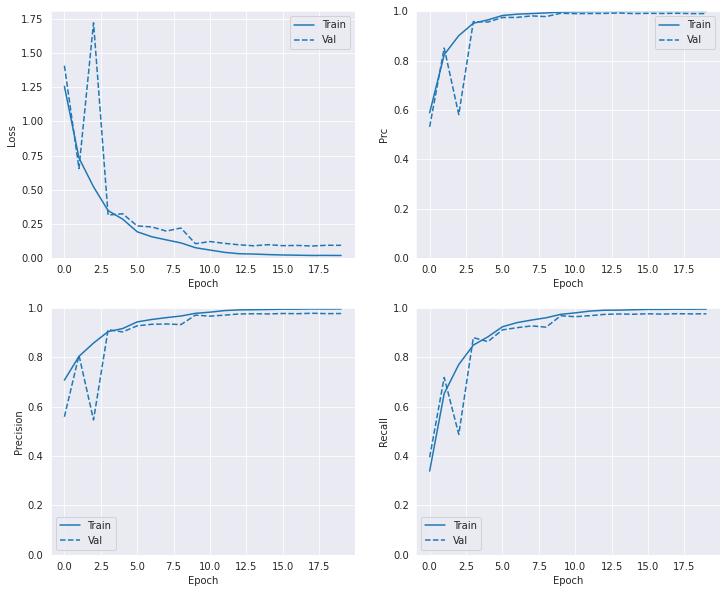

In [94]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

# Evaluate Model Accuracy

In [95]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[5])

# detail -> score = loss, acc --> score[0] = loss , score[1] = acc (kalo metricsnya loss sama acc aja)

367/367 [==============================] - 2s 7ms/step - loss: 0.0947 - tp: 11445.0000 - fp: 276.0000 - tn: 70128.0000 - fn: 289.0000 - accuracy: 0.9931 - precision: 0.9765 - recall: 0.9754 - auc: 0.9965 - prc: 0.9903
Test accuracy: 0.9931207895278931


# Visualization Accuracy and Validation Accuracy Model

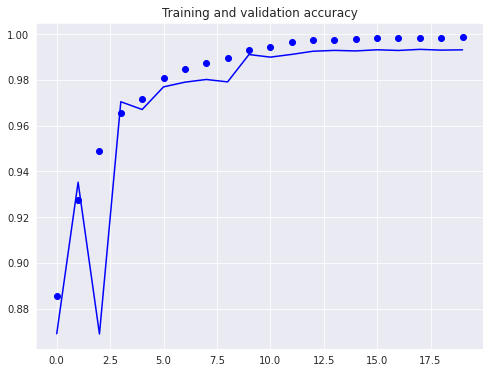

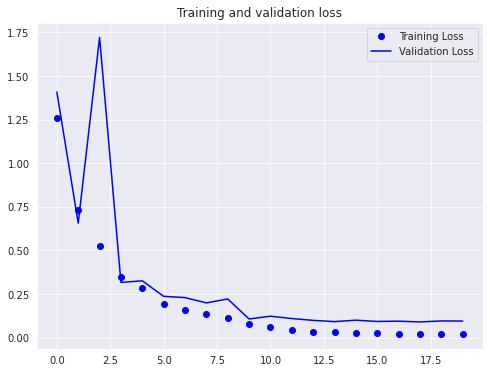

In [96]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Using Function of Model Predict

In [97]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

# Testing Model

In [103]:
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(28, 28))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

  cancer_class = np.argmax(classes)

  if cancer_class == 0:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) akiec')

  elif cancer_class == 1:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) bcc')

  elif  cancer_class == 2:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) bkl')

  elif  cancer_class == 3:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) df')

  elif cancer_class == 4:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) nv')

  elif cancer_class == 5:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) vasc')

  elif cancer_class == 6:
    print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) mel')

Saving ISIC_0024326.jpg to ISIC_0024326.jpg
Saving ISIC_0024327.jpg to ISIC_0024327.jpg
Saving ISIC_0024334.jpg to ISIC_0024334.jpg
Saving ISIC_0024354.jpg to ISIC_0024354.jpg
Saving ISIC_0024364.jpg to ISIC_0024364.jpg
Saving ISIC_0024389.jpg to ISIC_0024389.jpg
Saving ISIC_0024393.jpg to ISIC_0024393.jpg
Saving ISIC_0024399.jpg to ISIC_0024399.jpg
Saving ISIC_0024424.jpg to ISIC_0024424.jpg
Saving ISIC_0024462.jpg to ISIC_0024462.jpg
Saving ISIC_0024464.jpg to ISIC_0024464.jpg
Saving ISIC_0024478.jpg to ISIC_0024478.jpg
Saving ISIC_0024480.jpg to ISIC_0024480.jpg
Saving ISIC_0024487.jpg to ISIC_0024487.jpg
Saving ISIC_0024492.jpg to ISIC_0024492.jpg
Saving ISIC_0024502.jpg to ISIC_0024502.jpg
Saving ISIC_0024506.jpg to ISIC_0024506.jpg
Saving ISIC_0024518.jpg to ISIC_0024518.jpg
Saving ISIC_0024521.jpg to ISIC_0024521.jpg
Saving ISIC_0024528.jpg to ISIC_0024528.jpg
Saving ISIC_0024542.jpg to ISIC_0024542.jpg
Saving ISIC_0024558.jpg to ISIC_0024558.jpg
Saving ISIC_0024569.jpg to ISIC_

# Save Model

In [99]:
import time
# saved_model_path = "./{}.h5".format(int(time.time()))
saved_model_path = "./model_cutix.h5"
model.save(saved_model_path)

In [101]:
from sklearn.metrics import classification_report
Y_pred = model.predict(x_test).round()
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test, Y_pred, target_names = target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.99      1.00      0.99      1635
                             ('bcc', ' basal cell carcinoma')       0.98      1.00      0.99      1636
                     ('bkl', 'benign keratosis-like lesions')       0.95      0.98      0.97      1692
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00      1740
                                  ('nv', ' melanocytic nevi')       0.97      0.88      0.92      1699
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00      1611
                                          ('mel', 'melanoma')       0.95      0.97      0.96      1721

                                                    micro avg       0.98      0.98      0.98     11734
                                                    macro avg       0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
